<a href="https://colab.research.google.com/github/Sagaust/DH-Computational-Methodologies/blob/main/Exploring_iTune_Database_(_xml_db_file).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Step 1: Setup and XML Parsing**
First, you'll need to upload the XML file to Google Colab and parse it.

In [1]:
import xml.etree.ElementTree as ET
import sqlite3


## **Upload the XML File**
In Google Colab, use the file upload feature to upload your XML file. You can do this by clicking on the folder icon on the left sidebar and then the upload button.

## **Parse the XML File**
After uploading, parse the XML file to prepare for data extraction.

In [2]:
# Replace 'yourfile.xml' with the actual file name you uploaded
file_path = '/content/Library.xml'

# Parse the XML file
tree = ET.parse(file_path)
root = tree.getroot()

# Extract the third element (dict) which contains the actual data
data = root.findall('dict/dict/dict')
print("Number of entries in XML file:", len(data))


Number of entries in XML file: 404


## **Database Creation and Schema Setup**
Now, you'll create a SQLite database and define the schema.

In [3]:
# Create or open a SQLite database
conn = sqlite3.connect('music_library.db')
cur = conn.cursor()

# Define the schema for the database
cur.executescript('''
CREATE TABLE IF NOT EXISTS Artist (
    id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
    name TEXT UNIQUE
);

CREATE TABLE IF NOT EXISTS Genre (
    id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
    name TEXT UNIQUE
);

CREATE TABLE IF NOT EXISTS Album (
    id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
    artist_id INTEGER,
    title TEXT UNIQUE
);

CREATE TABLE IF NOT EXISTS Track (
    id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
    title TEXT UNIQUE,
    album_id INTEGER,
    genre_id INTEGER,
    len INTEGER, rating INTEGER, count INTEGER
);
''')


Data Extraction and Insertion
Extract data from the XML and insert it into the database.

In [4]:
#Define Helper Function
def lookup(d, key):
    found = False
    for child in d:
        if found: return child.text
        if child.tag == 'key' and child.text == key:
            found = True
    return None


In [14]:
# Assuming 'conn' and 'cur' are already set up for database connection

for entry in data:
    try:
        if (lookup(entry, 'Track ID') is None): continue

        name = lookup(entry, 'Name')
        artist = lookup(entry, 'Artist')
        album = lookup(entry, 'Album')
        genre = lookup(entry, 'Genre')
        count = lookup(entry, 'Play Count')
        rating = lookup(entry, 'Rating')
        length = lookup(entry, 'Total Time')

        if name is None or artist is None or album is None or genre is None:
            continue

        # Insert or ignore artist
        cur.execute('INSERT OR IGNORE INTO Artist (name) VALUES ( ? )', (artist, ))
        cur.execute('SELECT id FROM Artist WHERE name = ?', (artist, ))
        artist_id = cur.fetchone()[0]

        # Insert or ignore genre
        cur.execute('INSERT OR IGNORE INTO Genre (name) VALUES ( ? )', (genre, ))
        cur.execute('SELECT id FROM Genre WHERE name = ?', (genre, ))
        genre_id = cur.fetchone()[0]

        # Insert or ignore album
        cur.execute('INSERT OR IGNORE INTO Album (title, artist_id) VALUES ( ?, ? )', (album, artist_id))
        cur.execute('SELECT id FROM Album WHERE title = ?', (album, ))
        album_id = cur.fetchone()[0]

        # Insert or replace track
        cur.execute('''
            INSERT OR REPLACE INTO Track
            (title, album_id, genre_id, len, rating, count)
            VALUES ( ?, ?, ?, ?, ?, ? )''',
            (name, album_id, genre_id, length, rating, count))

        print(f"Inserted track: {name}, Artist: {artist}, Album: {album}, Genre: {genre}")

    except sqlite3.Error as e:
        print(f"SQLite error: {e}")
        break

conn.commit()



Inserted track: Another One Bites The Dust, Artist: Queen, Album: Greatest Hits, Genre: Rock
Inserted track: Asche Zu Asche, Artist: Rammstein, Album: Herzeleid, Genre: Industrial
Inserted track: Beauty School Dropout, Artist: Various, Album: Grease, Genre: Soundtrack
Inserted track: Black Dog, Artist: Led Zeppelin, Album: IV, Genre: Rock
Inserted track: Bring The Boys Back Home, Artist: Pink Floyd, Album: The Wall [Disc 2], Genre: Rock
Inserted track: Circles, Artist: Bryan Lee, Album: Blues Is, Genre: Funk
Inserted track: Comfortably Numb, Artist: Pink Floyd, Album: The Wall [Disc 2], Genre: Rock
Inserted track: Crazy Little Thing Called Love, Artist: Queen, Album: Greatest Hits, Genre: Rock
Inserted track: Electric Funeral, Artist: Black Sabbath, Album: Paranoid, Genre: Metal
Inserted track: Fat Bottomed Girls, Artist: Queen, Album: Greatest Hits, Genre: Rock
Inserted track: For Those About To Rock (We Salute You), Artist: AC/DC, Album: Who Made Who, Genre: Rock
Inserted track: Four

In [15]:
cur= conn.cursor()

In [10]:
# Connect to SQLite database
conn = sqlite3.connect('/content/music_library.db')
cur = conn.cursor()

In [20]:
# Query the sqlite_master table to view the schema
cur.execute("SELECT type, name, sql FROM sqlite_master WHERE type='table'")
schema = cur.fetchall()

for table_type, table_name, sql in schema:
    print(f"Table: {table_name}\nCreation SQL:\n{sql}\n")

Table: Artist
Creation SQL:
CREATE TABLE Artist (
    id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
    name TEXT UNIQUE
)

Table: sqlite_sequence
Creation SQL:
CREATE TABLE sqlite_sequence(name,seq)

Table: Genre
Creation SQL:
CREATE TABLE Genre (
    id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
    name TEXT UNIQUE
)

Table: Album
Creation SQL:
CREATE TABLE Album (
    id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
    artist_id INTEGER,
    title TEXT UNIQUE
)

Table: Track
Creation SQL:
CREATE TABLE Track (
    id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
    title TEXT UNIQUE,
    album_id INTEGER,
    genre_id INTEGER,
    len INTEGER, rating INTEGER, count INTEGER
)



In [21]:
#To understand the relationships, you can look for foreign key constraints in the table creation SQL.
for table_type, table_name, sql in schema:
    print(f"Table: {table_name}")
    if "FOREIGN KEY" in sql:
        print("Foreign Key Constraints:")
        for line in sql.split("\n"):
            if "FOREIGN KEY" in line:
                print(line.strip())
    else:
        print("No foreign key constraints.")
    print("\n")


Table: Artist
No foreign key constraints.


Table: sqlite_sequence
No foreign key constraints.


Table: Genre
No foreign key constraints.


Table: Album
No foreign key constraints.


Table: Track
No foreign key constraints.




## **Querying Data**
To retrieve data from the database, you can use SELECT statements.

In [16]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
tables = cur.fetchall()
for table in tables:
    print(table[0])


Artist
sqlite_sequence
Genre
Album
Track


In [17]:
cur.execute('SELECT COUNT(*) FROM Track')
count = cur.fetchone()[0]
print("Number of Track:", count)


Number of Track: 292


## **Print Debug Statements**
Add print statements in your code to check if the loop is being entered

In [19]:
cur.execute('SELECT * FROM Artist')
artists = cur.fetchall()
print("Fetching artists...")
for artist in artists:
    print(artist)
print("Done.")


Fetching artists...
(1, 'Queen')
(2, 'Rammstein')
(3, 'Various')
(4, 'Led Zeppelin')
(5, 'Pink Floyd')
(6, 'Bryan Lee')
(9, 'Black Sabbath')
(11, 'AC/DC')
(13, 'Rob Dougan')
(23, 'Frank Sinatra')
(31, 'America')
(55, 'Billy Price')
(58, 'The Canettes Blues Band')
(72, 'Fluke')
(86, 'The Who')
(95, 'Johnny Cash')
(103, 'Selah')
(118, 'Matt Ender')
(119, 'Steve McDonald')
(120, 'Altan')
(121, 'Chris Spheeris')
(122, 'La Esperanza')
(123, 'Luis Villegas')
(124, 'Rosa Passos')
(125, 'Energipsy')
(126, 'Hollie Smith')
(127, 'Joanie Madden')
(128, 'Cusco')
(129, 'Cheryl Gunn')
(130, 'Dean Everson')
(131, 'Jeff Bailey')
(132, 'Kaiser Chiefs')
(147, 'James Surowiecki')
(155, 'David Osborne')
(169, 'Fairly Legal')
(170, 'The Postal Service')
(171, 'Bing Crosby')
(183, 'Disturbed')
(195, 'Recording by Dr. Chuck')
(196, 'IEEE Computer Society')
(229, 'Jim Croce')
(233, 'Created by Sakai')
(249, 'Matt Pasiewicz')
(279, 'Undercover Boss')
(280, 'U2')
(281, 'The Black Crowes')
(295, 'Onion News Netw

## **Complex Queries with JOIN:**

In [23]:
cur.execute('''
SELECT Artist.name, Album.title, Track.title
FROM Track
JOIN Album ON Track.album_id = Album.id
JOIN Artist ON Album.artist_id = Artist.id
ORDER BY Artist.name LIMIT 10
''')
for row in cur.fetchall():
    print(row)


('AC/DC', 'Who Made Who', 'For Those About To Rock (We Salute You)')
('AC/DC', 'Who Made Who', 'Hells Bells')
('AC/DC', 'Who Made Who', 'Shake Your Foundations')
('AC/DC', 'Who Made Who', 'You Shook Me All Night Long')
('AC/DC', 'Who Made Who', 'Who Made Who')
('AC/DC', 'Who Made Who', 'D.T.')
('AC/DC', 'Who Made Who', 'Sink the Pink')
('AC/DC', 'Who Made Who', 'Ride On')
('AC/DC', 'Who Made Who', 'Chase the Ace')
('Billy Price', 'Danger Zone', 'Track 01')


In [24]:
cur.execute('SELECT * FROM Album LIMIT 5')
print(cur.fetchall())

cur.execute('SELECT * FROM Track LIMIT 5')
print(cur.fetchall())


[(1, 1, 'Greatest Hits'), (2, 2, 'Herzeleid'), (3, 3, 'Grease'), (4, 4, 'IV'), (5, 5, 'The Wall [Disc 2]')]
[(1, 'Another One Bites The Dust', 1, 1, 217103, 100, 55), (2, 'Asche Zu Asche', 2, 2, 231810, 100, 79), (3, 'Beauty School Dropout', 3, 3, 239960, 100, 48), (4, 'Black Dog', 4, 1, 296620, 100, 109), (5, 'Bring The Boys Back Home', 5, 1, 87118, 100, 33)]


## **Aggregate Functions**

In [25]:
cur.execute('''
SELECT Artist.name, COUNT(Track.id) as TrackCount
FROM Track
JOIN Album ON Track.album_id = Album.id
JOIN Artist ON Album.artist_id = Artist.id
GROUP BY Artist.name
ORDER BY TrackCount DESC
LIMIT 10
''')
for row in cur.fetchall():
    print(row)


('IEEE Computer Society', 34)
('Recording by Dr. Chuck', 22)
('Queen', 18)
('The Canettes Blues Band', 16)
('Created by Sakai', 16)
('Kaiser Chiefs', 15)
('David Osborne', 14)
('Matt Ender', 13)
('Disturbed', 12)
('Bryan Lee', 12)


## **Explore Relationships and Joins**
Perform LEFT JOIN:

In [26]:
cur.execute('''
SELECT Artist.name, Album.title
FROM Artist
LEFT JOIN Album ON Artist.id = Album.artist_id
LIMIT 10
''')
for row in cur.fetchall():
    print(row)


('Queen', 'Greatest Hits')
('Rammstein', 'Herzeleid')
('Various', 'Grease')
('Led Zeppelin', 'IV')
('Pink Floyd', 'The Wall [Disc 2]')
('Bryan Lee', 'Blues Is')
('Black Sabbath', 'Paranoid')
('AC/DC', 'Who Made Who')
('Rob Dougan', 'The Matrix Reloaded')
('Frank Sinatra', None)


## **Advanced SQL Features**
Creating Views:

In [27]:
cur.execute('''
CREATE VIEW popular_tracks AS
SELECT Track.title, Artist.name, COUNT(Track.id) as TrackCount
FROM Track
JOIN Album ON Track.album_id = Album.id
JOIN Artist ON Album.artist_id = Artist.id
GROUP BY Track.title
HAVING TrackCount > 10
''')
conn.commit()


Use the View:

In [28]:
cur.execute('SELECT * FROM popular_tracks LIMIT 10')
for row in cur.fetchall():
    print(row)


## **Data Visualization**

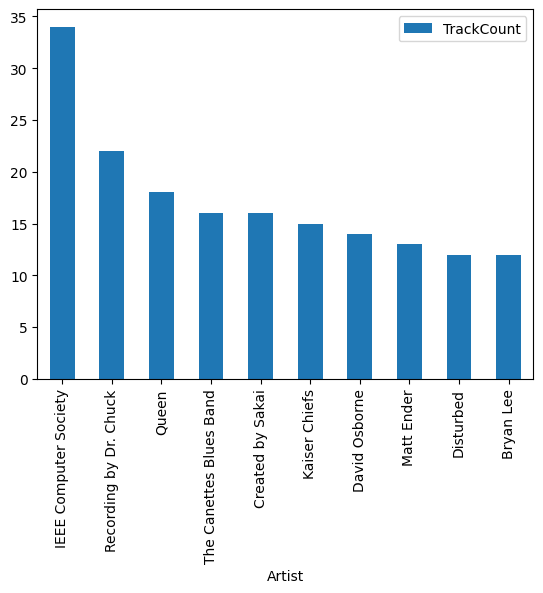

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

cur.execute('''
SELECT Artist.name, COUNT(Track.id) as TrackCount
FROM Track
JOIN Album ON Track.album_id = Album.id
JOIN Artist ON Album.artist_id = Artist.id
GROUP BY Artist.name
ORDER BY TrackCount DESC
LIMIT 10
''')
artists = cur.fetchall()

df = pd.DataFrame(artists, columns=['Artist', 'TrackCount'])
df.plot(kind='bar', x='Artist', y='TrackCount')
plt.show()


# **Export Data from SQLite**
## Export Tables as CSV Files:
 Use Python or a SQLite tool to export each table from your SQLite database to a CSV file. In Python, you can use the pandas library to do this:

In [32]:
import pandas as pd

In [33]:
# Export each table to a CSV file
tables = ['Artist', 'Genre', 'Album', 'Track']
for table in tables:
    df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
    df.to_csv(f"{table}.csv", index=False)
